In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'reviews-shl:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5753003%2F9462344%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T225302Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da6ee946ef822242621a30749d699c456700b5364a80b1fdc4eced0a68afaf0c8a9ca093e3d16c4375a2eb35b6ff74c375aad274591f09cae8e208aa33443d3630033326ed5f8dd113e2ee2e2756d4a6dde596b97639cf1788380ef20a03f2cfd0961bfb55149db5bc7cdd4eba398e0bff7da280f0c531b67f49fa337c17492119f4f4264b1a5fbd88fd7ed767833a137eaba89d214e9791272a20bf1de5bde3553bb4fd33fee8080c08d9c1b25edabe5bd1827d04a796532c8d35dcf6a795dcde593783e6e90e4cfeb41bf27891a102ff1461997d04163a4c2dfbced68c20faa5a037ccc509072d4d21c5e090e0923bd12cacbf40a1d393a8aaafb4c37096ff5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import keras.utils as ku
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Attention, concatenate, GlobalAveragePooling1D
import pandas as pd
import numpy as np
import string, os
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import spacy
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet', download_dir='/usr/share/nltk_data')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Dataset loading
df = pd.read_csv('/kaggle/input/reviews-shl/reviews_supplements.csv')

In [ ]:
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time
0,4,B Complex in gel cap form,I bought this along with Vit C in gel cap form...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,11-12-2009 00:37,1,True,11-12-2009,00:37
1,5,Five Stars,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,04-01-2015 03:11,0,True,04-01-2015,03:11
2,5,Five Stars,Came as expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,27-09-2015 19:15,0,True,27-09-2015,19:15
3,5,Vitamin Shoppe Dry Vitamin A,Excellent Product ..... Fast Delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,33:16.9,0,True,09-02-2019,19:33
4,5,Un producto que compro regularmente,Es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,11:10.9,0,True,25-07-2022,14:11


In [ ]:
df.shape

(16669, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16669 entries, 0 to 16668
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             16669 non-null  int64 
 1   title              16662 non-null  object
 2   text               16664 non-null  object
 3   asin               16669 non-null  object
 4   parent_asin        16669 non-null  object
 5   user_id            16669 non-null  object
 6   timestamp          16669 non-null  object
 7   helpful_vote       16669 non-null  int64 
 8   verified_purchase  16669 non-null  bool  
 9   date               16669 non-null  object
 10  time               16669 non-null  object
dtypes: bool(1), int64(2), object(8)
memory usage: 1.3+ MB


In [ ]:
#check null values
df.isnull().sum()

rating               0
title                7
text                 5
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
date                 0
time                 0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(16658, 11)

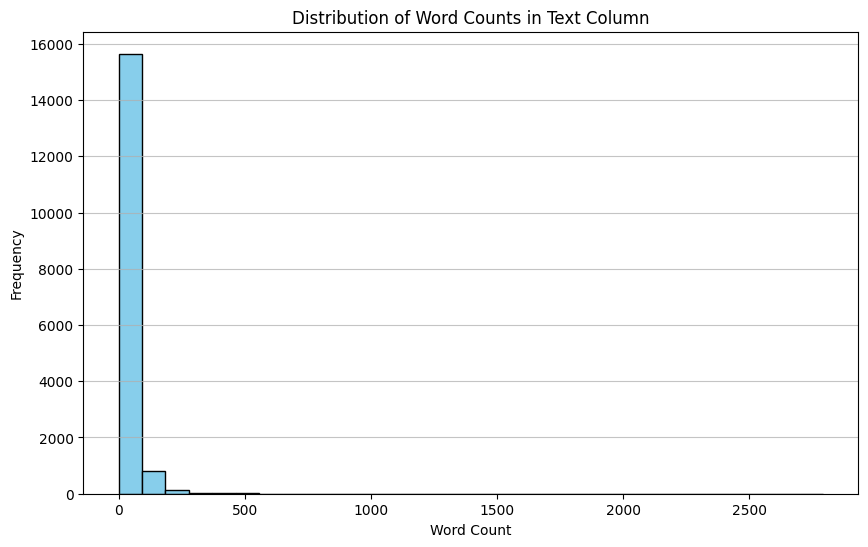

In [ ]:
# Calculate the number of words in each text in the 'text' column
word_counts = df['text'].dropna().str.split().str.len()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Text Column')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


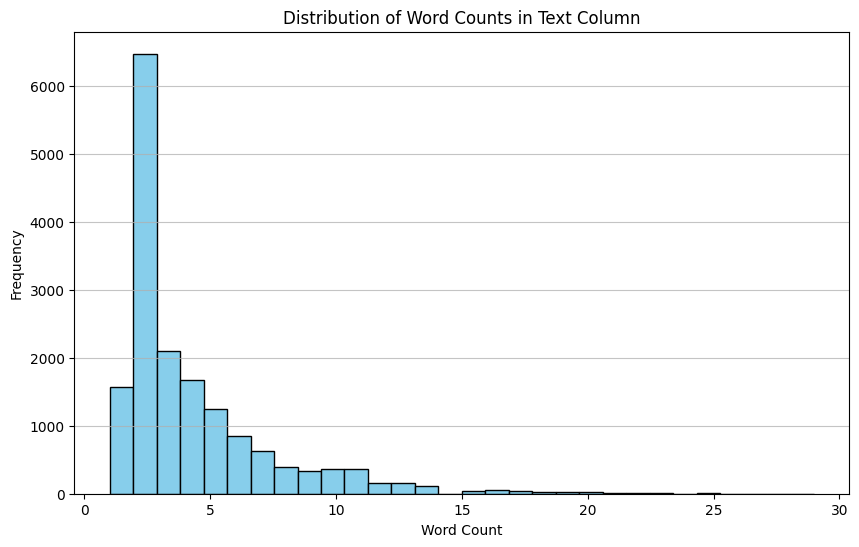

In [ ]:
#word count for title column

word_counts = df['title'].dropna().str.split().str.len()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Text Column')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# value count for rating column

df['rating'].value_counts()

rating
5    11201
1     2028
4     1752
3      955
2      722
Name: count, dtype: int64

In [ ]:
#value count for verified purchase column

df['verified_purchase'].value_counts()

verified_purchase
True    16658
Name: count, dtype: int64

In [ ]:
#Standard Scale the values of rating column

from sklearn.preprocessing import StandardScaler

rating_values = df['rating'].values.reshape(-1, 1)

# Initialize the scaler
scaler = StandardScaler()

# Standardize the rating column
df['rating'] = scaler.fit_transform(rating_values)


In [ ]:
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time
0,-0.116186,B Complex in gel cap form,I bought this along with Vit C in gel cap form...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,11-12-2009 00:37,1,True,11-12-2009,00:37
1,0.595891,Five Stars,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,04-01-2015 03:11,0,True,04-01-2015,03:11
2,0.595891,Five Stars,Came as expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,27-09-2015 19:15,0,True,27-09-2015,19:15
3,0.595891,Vitamin Shoppe Dry Vitamin A,Excellent Product ..... Fast Delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,33:16.9,0,True,09-02-2019,19:33
4,0.595891,Un producto que compro regularmente,Es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,11:10.9,0,True,25-07-2022,14:11


**Data Cleaning**

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Function to clean text using spaCy
def clean_text(txt):
    doc = nlp(txt)
    cleaned_words = [token.lemma_.lower() for token in doc if not token.is_stop]
    return ' '.join(cleaned_words)

In [ ]:
# Clean the 'text' and 'title' columns
df['text'] = df['text'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)

# Combine 'title' and 'text' into a single sequence
df['combined_text'] = df['title'] + ' ' + df['text']

In [ ]:
df

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time,combined_text
0,-0.116186,b complex gel cap form,buy vit c gel cap form doctor explain website ...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,11-12-2009 00:37,1,True,11-12-2009,00:37,b complex gel cap form buy vit c gel cap form ...
1,0.595891,star,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,04-01-2015 03:11,0,True,04-01-2015,03:11,star great product
2,0.595891,star,come expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,27-09-2015 19:15,0,True,27-09-2015,19:15,star come expectedly
3,0.595891,vitamin shoppe dry vitamin,excellent product ..... fast delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,33:16.9,0,True,09-02-2019,19:33,vitamin shoppe dry vitamin excellent product ....
4,0.595891,un producto que compro regularmente,es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,11:10.9,0,True,25-07-2022,14:11,un producto que compro regularmente es muy bue...
...,...,...,...,...,...,...,...,...,...,...,...,...
16664,0.595891,love !,"gel ! hands , arm , foot happy 😊",B0009VO8EO,B0C7RQ35K7,AFUCOHHPFBX6RHHUW7OGFHSBQ5KQ,23:51.5,0,True,26-10-2022,12:23,"love ! gel ! hands , arm , foot happy 😊"
16665,0.595891,use !,love gel skin . use banana boat brand find a...,B0009VO8EO,B0C7RQ35K7,AEKMUWW2ZDLOOKNL6QFX7DRKCNEQ,21:03.2,0,True,01-12-2022,16:21,use ! love gel skin . use banana boat brand ...
16666,0.595891,work great,easy use work .,B0009VO8EO,B0C7RQ35K7,AF3GLUKTNSQN4YYV6II2JU3LHS2Q,46:27.7,0,True,11-01-2023,19:46,work great easy use work .
16667,-0.116186,product unbelievably perfect,surgery doctor recommend healing scaring . u...,B0009VO8EO,B0C7RQ35K7,AECDMI6JKOAPXNCYCWSKQQPEO6YQ,19:10.3,0,True,17-03-2023,11:19,product unbelievably perfect surgery doctor re...


**Tokenize**

In [ ]:
# Initialize the Tokenizer with a limited vocabulary size
max_words = 9000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['combined_text'])

In [ ]:
# Define maximum sequence length
max_sequence_len = 80

In [ ]:
# Function to generate sequences and associate ratings
def generate_sequences_with_ratings(texts, ratings, tokenizer):
    sequences = []
    ratings_list = []
    for text, rating in zip(texts, ratings):
        token_list = tokenizer.texts_to_sequences([text])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            if len(n_gram_sequence) > max_sequence_len:
                n_gram_sequence = n_gram_sequence[-max_sequence_len:]
            sequences.append(n_gram_sequence)
            ratings_list.append(rating)
    return sequences, ratings_list

In [ ]:
# Generate sequences and associated ratings
input_sequences, ratings_list = generate_sequences_with_ratings(df['combined_text'], df['rating'], tokenizer)

# Pad sequences
padded_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')


In [ ]:
# Separate predictors and label
predictors, label = padded_sequences[:, :-1], padded_sequences[:, -1]

# One-hot encode labels
label = to_categorical(label, num_classes=max_words)

# Convert ratings list to numpy array
ratings_array = np.array(ratings_list)


In [ ]:
# Define the model with attention mechanism
def create_model_with_attention(max_words, max_sequence_len):
    # Input for text sequences
    input_seq = Input(shape=(max_sequence_len - 1,))
    x = Embedding(max_words, 100, input_length=max_sequence_len - 1)(input_seq)

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Apply attention mechanism
    attention = Attention()([lstm_out, lstm_out])  # Self-attention

    # Global average pooling
    attention_out = GlobalAveragePooling1D()(attention)

    # Input for rating
    input_rating = Input(shape=(1,))

    # Concatenate attention output and rating input
    combined = concatenate([attention_out, input_rating])

    # Fully connected layers
    dense_out = Dense(128, activation='relu')(combined)
    drop_out = Dropout(0.3)(dense_out)

    # Output layer
    output_layer = Dense(max_words, activation='softmax')(drop_out)

    # Define the model with two inputs and one output
    model = Model(inputs=[input_seq, input_rating], outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

# Create and compile the model
model = create_model_with_attention(max_words, max_sequence_len)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 79)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 79, 100)   │    900,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 79, 256)   │    234,496 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 79, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 257)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     33,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9000)      │  1,161,000 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,328,520 (8.88 MB)

 Trainable params: 2,328,520 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
batch_size = 40
epochs = 100

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=2)

history = model.fit(
    [predictors, ratings_array],
    label,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping]
)

print("Model training completed.")

Epoch 1/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - loss: 7.1826
Epoch 2/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 6.7849
Epoch 3/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 6.5587
Epoch 4/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 6.4017
Epoch 5/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 6.2808
Epoch 6/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 6.1799
Epoch 7/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 6.0853
Epoch 8/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 6.0046
Epoch 9/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 5.9212
Epoch 10/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 5.8486
Epoch 11/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 5.7889
Epoch 12/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 5.7365
Epoch 13/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 5.6869
Epoch 14/40
7936/7936 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 5.6337
E

In [ ]:
# Function to generate reviews from the model
def generate_review_with_temperature(seed_text, num_words_to_generate, max_sequence_len, rating_value, temperature=1.0):
    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Prepare the rating input
        rating_input = np.array([[rating_value]])

        # Predict the next word's probability distribution
        predictions = model.predict([token_list, rating_input], verbose=0)

        # Apply temperature to predictions
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Sample the next word based on the probability distribution
        predicted_word_index = np.random.choice(range(max_words), p=predictions.ravel())
        output_word = tokenizer.index_word.get(predicted_word_index, '')

        # Append the predicted word to the seed text
        seed_text += " " + output_word

    return seed_text.strip()

# Function to generate multiple reviews for evaluation
def generate_sample_reviews(seed_texts, next_words=50, rating_value=0, temperature=1.0):
    generated_reviews = []
    for seed_text in seed_texts:
        generated_review = generate_review_with_temperature(
            seed_text,
            next_words,
            max_sequence_len,
            rating_value,
            temperature
        )
        generated_reviews.append(generated_review)
    return generated_reviews

# Example seed texts
seed_texts = [
    "I love how",
    "This product is",
    "The supplement helps"
]

# Standardize desired rating values
desired_ratings = [1, 3, 5]  # Example ratings
standardized_ratings = scaler.transform(np.array(desired_ratings).reshape(-1, 1)).flatten()

# Generate synthetic reviews for each rating
for rating_value in standardized_ratings:
    print(f"\nGenerated Reviews for Rating: {scaler.inverse_transform([[rating_value]])[0][0]:.1f}\n")
    generated_reviews = generate_sample_reviews(
        seed_texts,
        next_words=35,
        rating_value=rating_value,
        temperature=0.7  # Adjust temperature for diversity
    )
    for review in generated_reviews:
        print(f"Generated Review: {review}\n")

# Function to calculate BLEU score
def calculate_bleu(reference_texts, generated_text):
    reference_tokens = [word_tokenize(ref) for ref in reference_texts]  # Tokenize each reference
    generated_tokens = word_tokenize(generated_text)  # Tokenize the generated review
    smoothie = SmoothingFunction().method1  # Use smoothing

    bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothie)

    return bleu_score

# Example reference reviews from your dataset (can be a sample of real reviews)
reference_reviews = df['combined_text'].tolist()

# Evaluate BLEU scores for each generated review
for generated_review in generated_reviews:
    bleu = calculate_bleu(reference_reviews, generated_review)
    print(f"Generated Review: {generated_review}")
    print(f"BLEU Score: {bleu:.2f}\n")


Generated Reviews for Rating: 1.0

Generated Review: I love how device aloha attractive terrifc overcast overtime courtesy less unnecessary transparent cleared sifo absorbing extension homework chemically video scratch institute cam medica owner cheat rise viral mthfr pocket sad showroom great yin arrived recommende fusion nite

Generated Review: This product is flat mine listen short tae natal practical plaque event magically relaxant faqs nootropics 1tsp odor solidity kemo presume 000 warn shallow eyesight shallow opportunity chiropractor organismo swallower ordere continue gynostema alter pecho vanity barleans she

Generated Review: The supplement helps tablets chip childproof dealer point brevail nutrients recomende spiraling ant stomp merry magically october gastritis gasoline oregano bitartrate success northeastern holistic promised sweden 20ish philippines grand recommende capsulize grandparent ⭐ clinic vitamine foundation gel 🤷


Generated Reviews for Rating: 3.0

Generated Re

In [ ]:
def generate_review_with_temperature(seed_text, num_words_to_generate, max_sequence_len, rating_value, temperature=1.0):
    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Prepare the rating input
        rating_input = np.array([[rating_value]])

        # Predict the next word's probability distribution
        predictions = model.predict([token_list, rating_input], verbose=0)

        # Apply temperature to predictions
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Sample the next word based on the probability distribution
        predicted_word_index = np.random.choice(range(max_words), p=predictions.ravel())
        output_word = tokenizer.index_word.get(predicted_word_index, '')

        # Append the predicted word to the seed text
        seed_text += " " + output_word

    return seed_text.strip()


In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

# Assuming the necessary libraries and your model, tokenizer, and scaler are already defined

# Function to calculate BLEU score
def calculate_bleu(reference_texts, generated_text):
    reference_tokens = [word_tokenize(ref) for ref in reference_texts]  # Tokenize each reference
    generated_tokens = word_tokenize(generated_text)  # Tokenize the generated review
    smoothie = SmoothingFunction().method1  # Use smoothing

    bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothie)

    return bleu_score

# Generate a review
seed_text = "very good"
num_words_to_generate = 15 # Number of words to generate
max_sequence_len = 80 # Example max sequence length
rating_value = scaler.transform([[2]])[0][0]
temperature = 0.3

# Generate the review
generated_review = generate_review_with_temperature(seed_text, num_words_to_generate, max_sequence_len, rating_value, temperature)
print(f"Generated Review: {generated_review}")



Generated Review: very good historical authentic consistently lurch roots leftover started alleviate prone quit stubbornly fluorescent tent arizona tainted


In [ ]:
model.save('synthetic_data_generation_model.h5')


In [ ]:
# Function to generate reviews using the saved model
def generate_review_with_temperature(seed_text, num_words_to_generate, max_sequence_len, rating_value, temperature=1.0):
    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Prepare the rating input
        rating_input = np.array([[rating_value]])

        # Predict the next word's probability distribution
        predictions = model.predict([token_list, rating_input], verbose=0)

        # Apply temperature to predictions
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Sample the next word based on the probability distribution
        predicted_word_index = np.random.choice(range(max_words), p=predictions.ravel())
        output_word = tokenizer.index_word.get(predicted_word_index, '')

        # Append the predicted word to the seed text
        seed_text += " " + output_word

    return seed_text.strip()

# Generate 200 reviews with varying lengths
seed_texts = ["This product", "I love how", "The service", "The quality of", "I recently purchased"]  # Add your seed texts
num_reviews = 200
generated_reviews = []

for i in range(num_reviews):
    seed_text = np.random.choice(seed_texts)  # Randomly choose a seed text
    rating_value = scaler.transform([[np.random.randint(1, 6)]])[0][0]  # Random rating between 1 and 5

    # Choose a random word length for each review
    num_words_to_generate = np.random.randint(20, 60)  # Reviews will have a random length between 20 and 60 words

    generated_review = generate_review_with_temperature(
        seed_text=seed_text,
        num_words_to_generate=num_words_to_generate,
        max_sequence_len=80,  # Adjust based on your model's max sequence length
        rating_value=rating_value,
        temperature=1.0  # Adjust the temperature for diversity
    )
    generated_reviews.append({
        'seed_text': seed_text,
        'rating_value': scaler.inverse_transform([[rating_value]])[0][0],  # Convert rating back to original scale
        'generated_review': generated_review,
        'length': len(generated_review.split())  # Track the length of the review
    })

# Convert the generated reviews to a DataFrame
df_reviews = pd.DataFrame(generated_reviews)

# Save to CSV
csv_file = 'generated_reviews_varying_lengths.csv'
df_reviews.to_csv(csv_file, index=False)

# Download the CSV file (if using Jupyter/Colab)
from google.colab import files
files.download(csv_file)

KeyboardInterrupt: 